# <span style="color:#a4d4a3">**Particle Filter Localization**</span>

### 🎯 <span style="color:#a4d4a3">**Short intro to PF & Monte Carlo Localization**</span>

- Kalman Filter and variants only model <span style="color:#ffa500">**Gaussian**</span> distributions.

<span style="color:#00703c">**Goal:**</span>

- Be able to handle <span style="color:#ffa500">**arbitrary**</span> distributions.

The main idea of the <span style="color:#00703c">**Particle Filter**</span> is:
- Use <span style="color:#ffa500">**multiple samples**</span> (particles) to represent the belief over a pose.
- The more samples in a region, the <span style="color:#ffa500">**higher the probability**</span>.
- Assign <span style="color:#ffa500">**weights**</span> to samples; larger weight ⇒ higher probability.

---


### 🔸 <span style="color:#a4d4a3">**Particle Set**</span>

The <span style="color:#ffa500">**particles**</span> are a set of weighted samples:

$$
\mathcal{X} = \left\{\left\langle x_t^{[j]},\,w_t^{[j]}\right\rangle\right\}_{j=1,\ldots,J}
$$

where:

- $x_t^{[j]}$ is a <span style="color:#ffa500">**state hypothesis**</span> and
- $w_t^{[j]}$ is the <span style="color:#ffa500">**importance weight**</span>.


The samples represent the <span style="color:#ffa500">**posterior**</span>:

$$
p(x)\ \approx\ \sum_{j=1}^{J} w^{[j]}\,\delta_{x^{[j]}}(x)
$$

where $\delta_x$ is the <span style="color:#ffa500">**Dirac**</span> distribution.

> 📝 <span style="color:#0098ff">**Note:**</span> <em>If we want more accurate representation we need more samples. Also the bigger/complex the function we are trying to describe, the more samples we need. This directly affects the computational demands.</em>

The main <span style="color:#ffa500">**idea**</span> is to use many samples (particles) to approximate a target distribution. The denser the particles in a region, the <span style="color:#ffa500">**higher**</span> the estimated probability of that region. Below we plot two examples:
- On the <span style="color:#ffa500">**left**</span> a unimodal Gaussian.
- On the <span style="color:#ffa500">**right**</span> a multi-modal mixture.

The <span style="color:#ffa500">**rug marks**</span> on the x-axis show particle locations.

In [57]:
# --- Particles for Approximation: unimodal vs. multimodal ---
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

# ---- target pdfs ----
def normal_pdf(x, mu=0.0, sigma=1.0):
    c = 1.0 / (np.sqrt(2*np.pi) * sigma)
    return c * np.exp(-0.5 * ((x - mu)/sigma)**2)

def mix2_pdf(x, w=0.45, mu1=-2.0, s1=0.7, mu2=1.5, s2=0.4):
    return w*normal_pdf(x, mu1, s1) + (1-w)*normal_pdf(x, mu2, s2)

def sample_mix2(n, w=0.45, mu1=-2.0, s1=0.7, mu2=1.5, s2=0.4, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    sel = rng.uniform(size=n) < w
    x = np.empty(n)
    x[sel]  = rng.normal(mu1, s1, sel.sum())
    x[~sel] = rng.normal(mu2, s2, (~sel).sum())
    return x

# ---- draw samples ----
J = 3000  # number of particles
samples_uni = rng.normal(0.0, 1.0, J)
samples_mix = sample_mix2(J, rng=rng)

# ---- plotting ----
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Ranges for pdf curves
x1 = np.linspace(-4, 4, 600)
x2 = np.linspace(-5, 4, 600)

# Left: unimodal Gaussian
ax = axes[0]
ax.plot(x1, normal_pdf(x1, 0.0, 1.0), lw=2.5, color='crimson', label='f(x)')
ax.hist(samples_uni, bins=60, density=True, histtype='stepfilled', alpha=0.25, color='crimson')
ax.plot(samples_uni, np.full_like(samples_uni, ax.get_ylim()[0]), '|', ms=20, color='black', alpha=0.5)  # rug
ax.set_xlabel('x')
ax.set_ylabel('probability / weight')
ax.set_title('Unimodal: Gaussian')
ax.legend(loc='upper right', frameon=False)

# Right: bimodal mixture
ax = axes[1]
ax.plot(x2, mix2_pdf(x2), lw=2.5, color='steelblue', label='f(x)')
ax.hist(samples_mix, bins=60, density=True, histtype='stepfilled', alpha=0.25, color='steelblue')
ax.plot(samples_mix, np.full_like(samples_mix, ax.get_ylim()[0]), '|', ms=20, color='black', alpha=0.5)  # rug
ax.set_xlabel('x')
ax.set_title('Multi-modal: Gaussian Mixture')
ax.legend(loc='upper right', frameon=False)

for ax in axes:
    ax.margins(x=0.02)
    ax.grid(alpha=0.15)

fig.tight_layout()

---

##### <span style="color:#a4d4a3">How to obtain such samples?</span>

<span style="color:#ffa500">**Closed-form sampling**</span> is only possible for a few distributions.
- Example: Gaussian - $\frac{1}{2} \sum_{i=1}^{12} \text{rand}(-\sigma, \sigma) $


How to <span style="color:#ffa500">**sample**</span> from <span style="color:#ffa500">**other**</span> distributions?

$\quad\quad$ **↳** use <span style="color:#ffa500">**importance sampling**</span>.

---


### 📊 <span style="color:#a4d4a3">**Importance Sampling Principle**</span>

We can use a different <span style="color:#ffa500">**proposal**</span> distribution $g(x)$ to generate samples from the <span style="color:#ffa500">**target**</span> distribution $f(x)$.

- Account for the difference with a weight $w(x)$:

$$
w(x)\ \propto\ \frac{f(x)}{g(x)}
$$

**Pre-condition:**

- if $f(x)>0 \to g(x)>0$.

In the example below, we compare <span style="color:#ffa500">**two proposals**</span>  for approximating a <span style="color:#ffa500">**bimodal**</span>  target density $f(x)$ using <span style="color:#ffa500">**importance sampling**</span> . We draw samples $x^{[j]} \sim g(x)$ and assign weights $w^{[j]} \propto \frac{f(x^{[j]})}{g(x^{[j]})}$.

True mean ≈ 0.470 | IS mean (good) ≈ 0.498 | IS mean (bad) ≈ 0.307


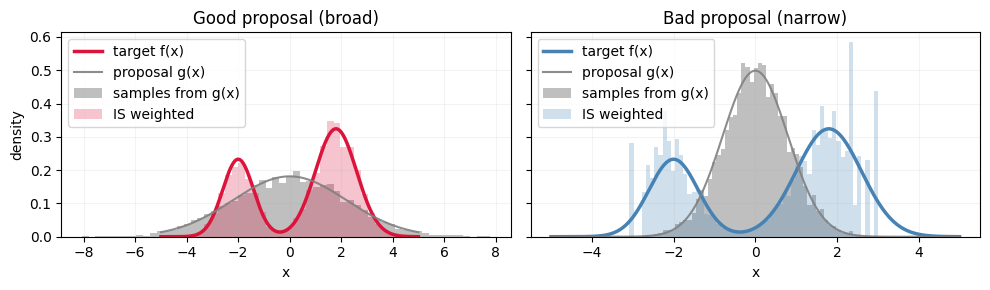

In [1]:
# --- Importance Sampling demo: recovering a target pdf from proposal samples ---
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(2)

# ---- utilities ----
def normal_pdf(x, mu, sigma):
    return (1.0 / (np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*((x-mu)/sigma)**2)

# Target: bimodal mixture (normalized)
def target_pdf(x):
    return 0.35*normal_pdf(x, -2.0, 0.6) + 0.65*normal_pdf(x, 1.8, 0.8)

# Proposals (both positive everywhere)
def g_good_pdf(x):  # broad, covers both modes well
    return normal_pdf(x, 0.0, 2.2)

def g_bad_pdf(x):   # too narrow, poor tail/mode coverage
    return normal_pdf(x, 0.0, 0.8)

def sample_g_good(n, rng):
    return rng.normal(0.0, 2.2, n)

def sample_g_bad(n, rng):
    return rng.normal(0.0, 0.8, n)

# ---- sampling ----
J = 5000
x_good = sample_g_good(J, rng)
x_bad  = sample_g_bad(J, rng)

# Unnormalized importance weights (proportional to f/g)
w_good = target_pdf(x_good) / g_good_pdf(x_good)
w_bad  = target_pdf(x_bad)  / g_bad_pdf(x_bad)

# Normalize for estimators (sum to 1)
w_good /= np.sum(w_good)
w_bad  /= np.sum(w_bad)

# Check a simple expectation: mean of x under f(x)
true_mean = 0.35*(-2.0) + 0.65*(1.8)  # mixture mean
is_mean_good = np.sum(w_good * x_good)
is_mean_bad  = np.sum(w_bad  * x_bad)
print(f"True mean ≈ {true_mean:.3f} | IS mean (good) ≈ {is_mean_good:.3f} | IS mean (bad) ≈ {is_mean_bad:.3f}")

# ---- plotting ----
xs = np.linspace(-5, 5, 800)
fxs = target_pdf(xs)

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Left: GOOD proposal
ax = axes[0]
ax.plot(xs, fxs, lw=2.5, color='crimson', label='target f(x)')
ax.plot(xs, g_good_pdf(xs), lw=1.5, color='gray', alpha=0.9, label='proposal g(x)')
# Unweighted histogram shows proposal density (for comparison)
ax.hist(x_good, bins=60, density=True,  alpha=0.5, color='gray', label='samples from g(x)')
# Weighted histogram approximates f(x)
ax.hist(x_good, bins=60, density=True, weights=w_good, alpha=0.25, color='crimson', label='IS weighted')
ax.set_title('Good proposal (broad)'); ax.set_xlabel('x'); ax.set_ylabel('density')
ax.legend(loc='upper left'); ax.grid(alpha=0.15)

# Right: BAD proposal
ax = axes[1]
ax.plot(xs, fxs, lw=2.5, color='steelblue', label='target f(x)')
ax.plot(xs, g_bad_pdf(xs), lw=1.5, color='gray', alpha=0.9, label='proposal g(x)')
ax.hist(x_bad, bins=60, density=True, alpha=0.5, color='gray', label='samples from g(x)')
ax.hist(x_bad, bins=60, density=True, weights=w_bad, alpha=0.25, color='steelblue', label='IS weighted')
ax.set_title('Bad proposal (narrow)'); ax.set_xlabel('x')
ax.legend(loc='upper left'); ax.grid(alpha=0.15)
fig.tight_layout()


<span style="color:#ffa500">**Takeaway:**</span> 

- A well-matched proposal yields a weighted histogram that closely follows $f$; a poor proposal leads to <span style="color:#ffa500">**few dominating weights**</span> and a noisy approximation.

---


### 📍 <span style="color:#a4d4a3">**Particle Filter (PF)**</span>

The <span style="color:#ffa500">**Particle filter**</span> is a realization of the <span style="color:#ffa500">**recursive Bayes filter**</span>. More specifically, is a <span style="color:#ffa500">**non-parametric**</span> approach that does not maintain a closed-form distribution.

As we have already discussed so far, the key idea is to model any <span style="color:#ffa500">**arbitrary distribution**</span> using <span style="color:#ffa500">**samples**</span>. Thus the <span style="color:#ffa500">**two steps**</span> of the Bayes filter are:

- <span style="color:#00703c">**Prediction step:**</span> draw samples from the proposal distribution (use the <span style="color:#ffa500">**motion model**</span> to sample).
- <span style="color:#00703c">**Correction step:**</span> use the <span style="color:#ffa500">**observations**</span> to compute the correction or (weights).

The more samples we use, the better our estimate is going to be!

---

#### 👨🏻‍💻 <span style="color:#a4d4a3">**Particle Filter Algorithm**</span>

The <span style="color:#ffa500">**Particle Filter**</span> can be summarized in the following algorithm:

> <tt> <span style="color:#4D96FF">def</span> **<span style="color:#6BCB77">Particle_Filter</span>($\color{#ffa500}\mathcal{X}_{t-1}, \color{#ffa500}u_t, \color{#ffa500}z_t$):**    
>>
>> <span style="color:#FF2DD1">1.</span> $\bar{\mathcal{X}}_t = \mathcal{X}_t = \emptyset \quad$ <span style="color:#948979"># Init</span>
>>
>> <span style="color:#FF2DD1">2.</span> <span style="color:#e74c3c">for</span> $j=1$ <span style="color:#ffa500">to</span> $J$ <span style="color:#e74c3c">do</span>: $\quad$ <span style="color:#948979"># Iterate over all previous samples</span>    
>>>
>>> <span style="color:#FF2DD1">3.</span> $x_t^{[j]} \sim \pi(x_t) \quad$ <span style="color:#948979"># Sample from the proposal distribution</span>
>>>
>>> <span style="color:#FF2DD1">4.</span> $w_t^{[j]} = \frac{p(x_t^{[j]})}{\pi(x_t^{[j]})} \quad$ <span style="color:#948979"># Compute correction weight</span>
>>>
>>> <span style="color:#FF2DD1">5.</span> $\bar{\mathcal{X}}_t = \bar{\mathcal{X}}_t + \langle x_t^{[j]}, w_t^{[j]}\rangle \quad$ <span style="color:#948979"># Add to predicted sample set</span> 
>>
>><span style="color:#FF2DD1">6.</span> <span style="color:#e74c3c">endfor</span>
>>
>> <span style="color:#FF2DD1">7.</span> <span style="color:#e74c3c">for</span> $j=1$ <span style="color:#ffa500">to</span> $J$ <span style="color:#e74c3c">do</span>: $\quad$<span style="color:#948979"># Resample</span>  
>>>
>>><span style="color:#FF2DD1">8.</span> <span style="color:#ffa500">draw</span> $i \in 1, \ldots, J$ <span style="color:#ffa500">with probability</span> $\propto w_t^{[i]}$
>>>
>>><span style="color:#FF2DD1">9.</span> <span style="color:#ffa500">add</span> $x_t^{[i]}$ <span style="color:#ffa500">to</span> $\mathcal{X}_t$
>>>
>><span style="color:#FF2DD1">10.</span> <span style="color:#e74c3c">endfor</span>    
>>
>><span style="color:#FF2DD1">11.</span> <span style="color:#e74c3c">return</span> $\mathcal{X}_t$

---


### 🚙 <span style="color:#a4d4a3">**Monte Carlo Localization (MCL)**</span>

When we focus on <span style="color:#ffa500">**only localization**</span> and assume a **known map** (e.g., an occupancy grid), we can use <span style="color:#ffa500">**Monte Carlo Localization (MCL)**</span>.  

MCL is a <span style="color:#ffa500">**specialized instance**</span> of the <span style="color:#ffa500">**Particle Filter**</span> tailored to pose estimation with a fixed map.

- Each particle is a <span style="color:#ffa500">**pose hypothesis**</span>.
- <span style="color:#00703c">**Proposal**</span> is the <span style="color:#ffa500"> **motion model** </span>:

  $$
  x_t^{[j]} \sim p(x_t \mid x_{t-1}, u_t)
  $$

- <span style="color:#00703c">**Correction**</span> via the <span style="color:#ffa500">**observation model**</span> (with known map $m$):

  $$
  w_t^{[j]} = \frac{\text{target}}{\text{proposal}} \propto p(z_t \mid x_t, m)
  $$

If we revisit the <tt><span style="color:#6BCB77">Particle_Filter</span></tt> algorithm, then the MCL is the same but we replace lines <tt><span style="color:#FF2DD1">3.</span></tt> and <tt><span style="color:#FF2DD1">4.</span></tt> with:

>>>  <tt><span style="color:#FF2DD1">3.</span></tt> $x_t^{[j]} \sim p(x_t \mid x_{t-1}^{[j]}, u_t) \quad$ <span style="color:#948979"># Sample from the proposal distribution</span>
>>>
>>>  <tt><span style="color:#FF2DD1">4.</span></tt> $w_t^{[j]} = p(z_t \mid x_t^{[j]}) \quad$ <span style="color:#948979"># Compute correction weight</span>

> 📝 <span style="color:#0098ff">**Note:**</span> <em> The Particle Filter becomes the Monte Carlo Localization (MCL) approach when we are trying to solve the localizaiton problem and the proposal is chosen as the motion model. Then there is a more detailed derivation, showing that the importance weight becomes proportional to the obseravtion model.</em>

#### 🧫 <span style="color:#a4d4a3">**Resampling**</span>

Before we move into a `python` example of the Monte Carlo Localization, let's take a look into the <span style="color:#ffa500">**resampling**</span> step first.

The resampling step <span style="color:#ffa500">**updates the particle set**</span> by reallocating our <span style="color:#ffa500">**limited particle budget**</span>. It lets low-weight (unlikely) samples to *die out* and replicates high-weight ones, so the particle set <span style="color:#ffa500">**better captures the belief**</span> at each step.

- <span style="color:#00703c">**Prune**</span> low-weight (unlikely) particles — let weak hypotheses **die out**.
- <span style="color:#00703c">**Replicate**</span> high-weight (likely) particles — create **stronger** hypotheses.
- Concentrate computational effort on <span style="color:#00703c">**high-probability regions**</span> of the state space.
- <span style="color:#00703c">**Survival of the fittest**</span>; a trick to avoid many samples covering unlikely states.

##### <span style="color:#a4d4a3">Resampling Methods</span>

<span style="color:#00703c">**Roulette wheel resampling:**</span>

- Build the cumulative sum (CDF) of <span style="color:#ffa500">**normalized**</span> weights.  

- Draw $J$ independent uniforms $u_j \sim \mathcal{U}(0,1)$.  

- For each $u_j$, find the first CDF bin $\ge u_j$ (e.g., via <span style="color:#ffa500">**binary search**</span>) and copy that particle. 

- Complexity: $O(J \log J)$ with binary search.  

- Simple but <span style="color:#ffa500">**higher variance**</span>; a few high-weight particles may be chosen many times.



<span style="color:#00703c">**Stochastic universal sampling** (SUS)</span> 

- Build the CDF of <span style="color:#ffa500">**normalized**</span> weights.

- Draw a single random offset $r \sim \mathcal{U}(0, 1/J)$.  

- Place $J$ equally spaced pointers at $r,\, r+\tfrac{1}{J},\, r+\tfrac{2}{J},\dots, r+\tfrac{J-1}{J}$. 

- For each pointer, select the first CDF bin $\ge$ pointer and copy that particle.  

- Complexity: $O(J)$ using one pass through the CDF.  

- <span style="color:#ffa500">**Low variance**</span>; allocations are closer to the expected counts, reducing sample impoverishment compared to roulette.

---

##### 🎮 `Python Example: Monte Carlo Localization in an Occupancy Map`

This interactive, keyboard-driven demo implements MCL on a fixed occupancy grid using a <span style="color:#ffa500">**likelihood-field**</span> sensor model (precomputed distance transform). 

Particles are <span style="color:#ffa500">**snapped to free pixels**</span> and the displayed estimate <span style="color:#ffa500">**starts at a random free pose**</span>. 

**Lightweight implementation tricks:**

- <span style="color:#00703c">**ESS-triggered systematic resampling + random injection:**</span> We resample only when the **effective sample size** drops (e.g., $N_\text{eff}/N<\tau$), using **systematic** resampling for low variance, then replace a small fraction of particles with **uniform free-space** samples. This keeps diversity high and improves recovery.

- <span style="color:#00703c">**Top-K weighted read-out:**</span> The pose estimate is computed from the **highest-weight K%** particles instead of the entire cloud. This reduces bias from distant modes and yields a steadier, more reliable read-out during global localization.

- <span style="color:#00703c">**EMA smoothing** (visual only):</span> We apply a light **exponential moving average** to the displayed estimate. It damps jitter from stochastic resampling while leaving the underlying filter state untouched.

- <span style="color:#00703c">**Beam subsampling + hit-only beams:**</span> Using every $s$-th beam cuts measurement cost by $\sim s$ with minor accuracy loss, and **ignoring max-range (no-hit) beams** stabilizes the likelihood-field update in structured maps. Together, these keep updates fast and well-conditioned.

We provide more details to some of the steps, as well as tips on the parameters, right after the `python` code.

Press <span style="color:#ffa500">**G**</span> to reset the particles, or <span style="color:#ffa500">**K**</span> to reset the predicted pose. Press <span style="color:#ffa500">**P**</span> to turn on/off the drawing of the particels. Press <span style="color:#ffa500">**.**</span> or <span style="color:#ffa500">**,**</span> to increase/decreas the number of beam subsampling.

In [1]:
# ===================================================
# Fast & Stable MCL (Pixel-Quantized Particles)
# GT (left) | MCL (right; red particles)
# ===================================================

import sys
import numpy as np
import pygame

# --- Helpers ---
def wrap_angle(a: float) -> float:
    return (a + np.pi) % (2*np.pi) - np.pi

def i2(p):
    """(x,y) -> (int,int)"""
    return (int(p[0]), int(p[1]))

def circ_mean_thetas(th: np.ndarray, w: np.ndarray) -> float:
    """Compute the circular mean of angles.
    Args:
        th: (N,) array of angles in radians
        w:  (N,) array of weights (not necessarily normalized)
    Returns:
        single angle in radians
    """
    s = np.sum(w * np.sin(th)); c = np.sum(w * np.cos(th))
    return np.arctan2(s, c)

def blend_pose(prev: np.ndarray, cur: np.ndarray, alpha=0.5) -> np.ndarray:
    """EMA smoothing of pose; angle blended on the circle.
    Args:
        prev: (3,) previous pose (x,y,theta) or None
        cur:  (3,) current pose (x,y,theta)
        alpha: blending factor (0 <= alpha <= 1)
    Returns:
        (3,) blended pose (x,y,theta)
    """
    if prev is None: return cur.copy()
    x = (1-alpha)*prev[0] + alpha*cur[0]
    y = (1-alpha)*prev[1] + alpha*cur[1]
    dth = wrap_angle(cur[2] - prev[2])
    th  = wrap_angle(prev[2] + alpha*dth)
    return np.array([x,y,th], dtype=np.float32)

# -------------------- Config --------------------
class Config:
    panel_w, panel_h = 500, 400
    window_size = (panel_w*2, panel_h)
    floor_img_path = '../figures/floor_plan.png'

    # LiDAR
    num_beams   = 180
    fov_deg     = 360
    scan_ms     = 120
    ray_stride  = 2
    max_range_px = 250
    beam_subsample_step = 2

    # Motion (odometry-style command dr1, dt, dr2)
    trans_step = 12.0
    rot_step   = np.deg2rad(12.0)

    # Motion noise covariance (diagonal) for standard additive model
    R_x = np.diag([1.0**2, 1.0**2, (2.0 * np.pi / 180.0)**2]).astype(np.float32)

    # Likelihood-field model
    sigma_hit = 8.0           # [px] std of endpoint distance to nearest wall
    use_only_hit_beams = True # ignore max-range beams (poorly informative)

    # Particles / resampling (note: particles are pixels)
    Np = 1000
    resample_neff_ratio = 0.5
    random_injection_frac = 0.01

    # Estimation
    top_k_frac = 0.8          # estimate from top-K by weight (robust)
    smooth_alpha = 0.5        # EMA smoothing on pose estimate

    # Drawing
    draw_particles = True
    particle_color = (220, 40, 40)  # red like the screenshot
    draw_top_k_particles = None     # None = draw all

    seed = 0

# --- Panel ---
class Panel:
    def __init__(self, screen, rect): self.screen, self.rect = screen, rect
    @property
    def ox(self): return self.rect[0]
    def clear(self, color):
        pygame.draw.rect(self.screen, color, self.rect)
        pygame.draw.rect(self.screen, (200,200,200), self.rect, 2)
    def blit(self, surf, at=(0,0)):
        x,y,_,_ = self.rect; self.screen.blit(surf, (x+at[0], y+at[1]))
    def polygon(self, color, pts):
        x,y,_,_ = self.rect; P = [(x+int(px), y+int(py)) for (px,py) in pts]
        pygame.draw.polygon(self.screen, color, P)
    def circle(self, color, p, r):
        x,y,_,_ = self.rect; pygame.draw.circle(self.screen, color, (x+int(p[0]), y+int(p[1])), r)
    def text(self, font, s, color, pos):
        x,y,_,_ = self.rect; self.screen.blit(font.render(s, True, color), (x+pos[0], y+pos[1]))

# --- Map + distance field ---
class Map2D:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.surface = pygame.transform.smoothscale(
            pygame.image.load(cfg.floor_img_path), (cfg.panel_w, cfg.panel_h)
        )
        arr = pygame.surfarray.array3d(self.surface)  # (W,H,3) (x,y,RGB)
        self.wall_mask = np.all(arr < 128, axis=2).astype(np.bool_)  # True=wall
        self.free_mask = ~self.wall_mask
        # Precompute list of free pixel coordinates (x,y) for fast sampling
        free_xy = np.where(self.free_mask)          # tuple of (x_idx, y_idx)
        self.free_coords = np.stack(free_xy, axis=1).astype(np.int32)  # (Nfree,2)
        self.dist_field = self._build_distance_field()

    def _build_distance_field(self):
        W,H = self.wall_mask.shape
        try:
            import scipy.ndimage as ndi
            return ndi.distance_transform_edt(self.free_mask).astype(np.float32)
        except Exception:
            # chamfer fallback
            inf = 1e9
            df = np.full((W, H), inf, dtype=np.float32)
            df[self.wall_mask] = 0.0
            # forward pass
            for x in range(W):
                xm1 = x-1
                for y in range(H):
                    d = df[x,y]
                    if xm1 >= 0: d = min(d, df[xm1,y] + 1.0)
                    ym1 = y-1
                    if ym1 >= 0: d = min(d, df[x,ym1] + 1.0)
                    if (xm1 >= 0) and (ym1 >= 0): d = min(d, df[xm1,ym1] + np.sqrt(2.0))
                    xp1 = x+1
                    if (xp1 < W) and (ym1 >= 0): d = min(d, df[xp1,ym1] + np.sqrt(2.0))
                    df[x,y] = d
            # backward pass
            for x in range(W-1,-1,-1):
                xp1 = x+1
                for y in range(H-1,-1,-1):
                    d = df[x,y]
                    if xp1 < W: d = min(d, df[xp1,y] + 1.0)
                    yp1 = y+1
                    if yp1 < H: d = min(d, df[x,yp1] + 1.0)
                    if (xp1 < W) and (yp1 < H): d = min(d, df[xp1,yp1] + np.sqrt(2.0))
                    xm1 = x-1
                    if (xm1 >= 0) and (yp1 < H): d = min(d, df[xm1,yp1] + np.sqrt(2.0))
                    df[x,y] = d
            return df

    def cast_beam_fast(self, pos_xy: tuple, angle: float, max_r: float):
        """Cast a ray from pos_xy at given angle (radians) up to max_r pixels.
        Args:
            pos_xy: (x,y) start position in pixels (float)
            angle: angle in radians
            max_r: maximum range in pixels
        Returns:
            (x_hit, y_hit): hit position in pixels (int) or None if no hit
            r: distance to hit in pixels (int) or max_r if no hit
        """
        W, H = self.wall_mask.shape
        x0, y0 = float(pos_xy[0]), float(pos_xy[1])
        c, s = np.cos(angle), np.sin(angle)
        for d in range(0, int(max_r), self.cfg.ray_stride):
            x = int(x0 + d*c); y = int(y0 + d*s)
            if not (0 <= x < W and 0 <= y < H):
                return None, d
            if self.wall_mask[x, y]:
                return (x, y), d
        return None, int(max_r)

    def random_free_xy(self, rng: np.random.Generator):
        """Return a random FREE pixel (x,y) as float (center of pixel).
        Args:
            rng: np.random.Generator instance
        Returns:
            (x,y): coordinates of a FREE pixel (float)
        """
        idx = rng.integers(0, self.free_coords.shape[0])
        x, y = self.free_coords[idx]
        return float(x), float(y)

    def sample_free_pixels(self, rng: np.random.Generator, n: int, replace: bool = True):
        """Sample n FREE pixels (x,y) as integers.
        Args:
            rng: np.random.Generator instance
            n: number of pixels to sample
            replace: whether to sample with replacement
        Returns:
            (n,2) array of FREE pixel coordinates (int32)
        """
        total = self.free_coords.shape[0]
        replace = (n > total) or replace
        idx = rng.choice(total, size=n, replace=replace)
        return self.free_coords[idx].copy()  # (n,2) int32

    def nearest_free_to(self, x_c: float, y_c: float):
        """Nearest FREE pixel to a given (x_c,y_c).
        Args:
            x_c: x coordinate (float)
            y_c: y coordinate (float)
        Returns:
            (x,y): coordinates of the nearest FREE pixel (float)
        """
        dx = self.free_coords[:,0] - x_c
        dy = self.free_coords[:,1] - y_c
        j = np.argmin(dx*dx + dy*dy)
        fx, fy = self.free_coords[j]
        return float(fx), float(fy)

# --- LiDAR (GT scan) ---
class Lidar:
    def __init__(self, cfg: Config, world_map: Map2D):
        self.cfg = cfg; self.map = world_map

    def scan(self, pose_xyth: tuple, rng: np.random.Generator) -> tuple:
        """Simulate a LiDAR scan from given pose (x,y,theta).
        Args:
            pose_xyth: (x,y,theta) pose in world coordinates (float)
            rng: np.random.Generator instance
        Returns:
            (Z_r, Z_phi): range and bearing measurements (numpy arrays)
        """
        x, y, th = map(float, pose_xyth)
        fov = np.deg2rad(self.cfg.fov_deg)
        bearings = np.linspace(-fov/2, fov/2, self.cfg.num_beams, endpoint=False)
        Z_r = np.empty(self.cfg.num_beams, dtype=np.float32)
        Z_phi = np.empty_like(Z_r)
        for i, rel in enumerate(bearings):
            a = wrap_angle(th + rel)
            _, dist = self.map.cast_beam_fast((x, y), a, self.cfg.max_range_px)
            Z_r[i] = dist + rng.normal(0.0, 1.5)  # mild sensor noise
            Z_phi[i] = rel
        return Z_r, Z_phi

# --- bilinear sampler ---
def bilinear_sample(field: np.ndarray, xs: np.ndarray, ys: np.ndarray) -> np.ndarray:
    """Bilinear sampling of a 2D field at given (x,y) coordinates.
    Args:
        field: 2D array to sample from
        xs: x coordinates (float)
        ys: y coordinates (float)
    Returns:
        2D array of sampled values (float)
    """
    W, H = field.shape
    xs = np.clip(xs, 0.0, W-1.001); ys = np.clip(ys, 0.0, H-1.001)
    x0 = np.floor(xs).astype(np.int32); y0 = np.floor(ys).astype(np.int32)
    x1 = np.minimum(x0+1, W-1); y1 = np.minimum(y0+1, H-1)
    wx = xs - x0; wy = ys - y0
    v00 = field[x0, y0]; v10 = field[x1, y0]
    v01 = field[x0, y1]; v11 = field[x1, y1]
    return (v00*(1-wx)*(1-wy) + v10*wx*(1-wy) + v01*(1-wx)*wy + v11*wx*wy)

# --- Particle Filter (MCL, particles at pixels) ---
class ParticleFilterMCL:
    def __init__(self, cfg: Config, world_map: Map2D, rng):
        self.cfg, self.map, self.rng = cfg, world_map, rng
        self.N = cfg.Np
        self.x = np.zeros((self.N, 3), dtype=np.float32)   # (x,y,theta)
        self.w = np.ones(self.N, dtype=np.float32) / self.N
        self.global_initialize()

    def _snap_to_pixel(self):
        """Round positions to nearest pixel center (integer coordinates)."""
        self.x[:,0] = np.rint(self.x[:,0])
        self.x[:,1] = np.rint(self.x[:,1])

    def _repair_outside_or_wall(self, mask_bad: np.ndarray):
        """Reseed bad particles to random FREE pixels (keeps orientation).
        Args:
            mask_bad: (N,) boolean array, True for bad particles
        """
        if not np.any(mask_bad): return
        repl = self.map.sample_free_pixels(self.rng, int(mask_bad.sum()), replace=True)
        self.x[mask_bad, 0] = repl[:,0]
        self.x[mask_bad, 1] = repl[:,1]

    def global_initialize(self):
        # Sample FREE pixels (without replacement if possible)
        coords = self.map.sample_free_pixels(self.rng, self.N, replace=False)
        thetas = self.rng.uniform(-np.pi, np.pi, size=self.N).astype(np.float32)
        self.x[:,0] = coords[:,0]; self.x[:,1] = coords[:,1]; self.x[:,2] = thetas
        self.w.fill(1.0/self.N)

    def predict(self, u: tuple):
        """
        Standard motion model.
        Args:
            u: (dr1, dt, dr2) odometry command (float)        
        """
        dr1, dt, dr2 = float(u[0]), float(u[1]), float(u[2])
        th = self.x[:, 2]

        # Odometry motion (deterministic part)
        th_mid = th + dr1
        ct = np.cos(th_mid); st = np.sin(th_mid)
        x_new = self.x[:, 0] + dt * ct
        y_new = self.x[:, 1] + dt * st
        th_new = th + dr1 + dr2

        # Sample additive noise from N(0, R_x)
        std = np.sqrt(np.diag(self.cfg.R_x))
        noise = self.rng.normal(0.0, std, size=(self.N, 3))

        # Rotate translational noise from body to world
        ex_b, ey_b, eth = noise[:,0], noise[:,1], noise[:,2]
        ex_w = ct * ex_b - st * ey_b
        ey_w = st * ex_b + ct * ey_b

        # Add noise to motion
        self.x[:, 0] = x_new + ex_w
        self.x[:, 1] = y_new + ey_w
        self.x[:, 2] = np.array([wrap_angle(tn + e) for tn, e in zip(th_new, eth)], dtype=np.float32)

        # Snap and repair
        self._snap_to_pixel()
        xi = self.x[:,0].astype(np.int32); yi = self.x[:,1].astype(np.int32)
        W,H = self.map.wall_mask.shape
        inside = (xi >= 0) & (xi < W) & (yi >= 0) & (yi < H)
        ok = np.zeros(self.N, dtype=bool)
        ok[inside] = self.map.free_mask[xi[inside], yi[inside]]
        bad = ~ok
        self._repair_outside_or_wall(bad)

    def update(self, Z_r: np.ndarray, Z_phi: np.ndarray):
        """Measurement update (correction) step with LiDAR scan Z = (Z_r, Z_phi).
        Args:
            Z_r: (M,) array of range measurements (float)
            Z_phi: (M,) array of bearing measurements (float)
        """
        if Z_r.size == 0: return
        step = max(1, int(self.cfg.beam_subsample_step))
        r = Z_r[::step].astype(np.float32)
        phi = Z_phi[::step].astype(np.float32)
        if self.cfg.use_only_hit_beams:
            mask = r < (self.cfg.max_range_px - 1.5*self.cfg.ray_stride)
            if np.any(mask):
                r = r[mask]; phi = phi[mask]
            else:
                return
        th = self.x[:, 2][:, None]                 # (N,1)
        ang = th + phi[None, :]                    # (N,M)
        ex = self.x[:, 0][:, None] + r[None, :]*np.cos(ang)
        ey = self.x[:, 1][:, None] + r[None, :]*np.sin(ang)

        d = bilinear_sample(self.map.dist_field, ex, ey)  # (N,M)
        inv_2sig2 = 1.0 / (2.0 * self.cfg.sigma_hit * self.cfg.sigma_hit)
        log_lik = -np.mean(d*d, axis=1) * inv_2sig2

        logw = np.log(self.w + 1e-12) + log_lik
        m = np.max(logw)
        w = np.exp(logw - m); w /= (np.sum(w) + 1e-12)
        self.w = w.astype(np.float32)

    def neff(self):
        """Effective sample size."""
        return 1.0 / (np.sum(self.w**2) + 1e-12)

    def resample_if_needed(self):
        if self.neff() < self.cfg.resample_neff_ratio * self.N:
            self.systematic_resample()
            self.inject_random(int(self.cfg.random_injection_frac * self.N))

    def systematic_resample(self):
        N = self.N
        positions = (self.rng.random() + np.arange(N)) / N
        indexes = np.zeros(N, dtype=np.int32)
        c = self.w[0]; i = 0
        for j in range(N):
            u = positions[j]
            while u > c and i < N-1:
                i += 1; c += self.w[i]
            indexes[j] = i
        self.x = self.x[indexes].copy()
        self.w.fill(1.0/N)
        # Ensure we remain snapped after resampling
        self._snap_to_pixel()

    def inject_random(self, k: int):
        """Inject k random particles (replacing worst k by weight).
        Args:
            k: number of particles to inject
        """
        if k <= 0: return
        repl = self.map.sample_free_pixels(self.rng, k, replace=True)
        idx = self.rng.choice(self.N, size=k, replace=False)
        self.x[idx, 0] = repl[:,0]; self.x[idx, 1] = repl[:,1]
        self.x[idx, 2] = self.rng.uniform(-np.pi, np.pi, size=k).astype(np.float32)

    def estimate_topk(self, frac: float=0.2) -> np.ndarray:
        """Estimate pose from top-K particles by weight.
        Args:
            frac: fraction of particles to use (0 < frac <= 1)
        Returns:
            (3,) estimated pose (x,y,theta)
        """
        k = max(1, int(frac * self.N))
        idx = np.argsort(self.w)[-k:]
        w = self.w[idx]; w = w / (np.sum(w) + 1e-12)
        x = float(np.sum(w * self.x[idx,0]))
        y = float(np.sum(w * self.x[idx,1]))
        th = float(circ_mean_thetas(self.x[idx,2], w))
        return np.array([x,y,th], dtype=np.float32)

# --- App ---
class App:
    def __init__(self, cfg: Config):
        pygame.init()
        self.cfg = cfg
        self.screen = pygame.display.set_mode(cfg.window_size)
        pygame.display.set_caption("GT (left) | MCL (right)")
        self.clock  = pygame.time.Clock()
        self.font   = pygame.font.SysFont(None, 18)
        self.rng    = np.random.default_rng(cfg.seed)

        self.left  = Panel(self.screen, (0, 0, cfg.panel_w, cfg.panel_h))
        self.right = Panel(self.screen, (cfg.panel_w, 0, cfg.panel_w, cfg.panel_h))

        self.map   = Map2D(cfg)
        self.lidar = Lidar(cfg, self.map)

        # --- Start GT at the center (nearest FREE pixel) ---
        cx, cy = cfg.panel_w//2, cfg.panel_h//2
        gx, gy = self.map.nearest_free_to(cx, cy)
        self.gt_pose = np.array([gx, gy, 0.0], dtype=np.float32)
        self.gt_traj = [self.gt_pose.copy()]

        self.pf = ParticleFilterMCL(cfg, self.map, self.rng)
        self.frozen = True  # start frozen
        rx, ry = self.map.random_free_xy(self.rng)
        rth = self.rng.uniform(-np.pi, np.pi)
        self.est_pose = np.array([rx, ry, rth], dtype=np.float32)

        self.beam_angle = 0.0
        self.beam_speed = 2*np.pi*10
        self.SCAN_EVENT = pygame.USEREVENT + 1
        pygame.time.set_timer(self.SCAN_EVENT, cfg.scan_ms)

        self.last_scan = (np.array([], dtype=np.float32), np.array([], dtype=np.float32))
        self.draw_particles = cfg.draw_particles

    @staticmethod
    def motion_model_odometry(u: tuple, x_prev: np.ndarray) -> np.ndarray:
        """Apply odometry-style motion model to pose x_prev with command u = (dr1, dt, dr2).
        Args:
            u: (dr1, dt, dr2) odometry command (float)
            x_prev: (3,) previous pose (x,y,theta)
        Returns:
            (3,) new pose (x,y,theta)
        """
        dr1, dt, dr2 = u
        x_new = x_prev[0] + dt*np.cos(x_prev[2] + dr1)
        y_new = x_prev[1] + dt*np.sin(x_prev[2] + dr1)
        th_new= wrap_angle(x_prev[2] + dr1 + dr2)
        return np.array([x_new, y_new, th_new], dtype=np.float32)

    def step_motion(self, cmd: tuple):
        """
        Apply motion model to ground truth pose and predict particle states.
        """
        self.frozen = False
        self.gt_pose = self.motion_model_odometry(cmd, self.gt_pose)
        self.gt_traj.append(self.gt_pose.copy()); self.gt_traj = self.gt_traj[-300:]
        self.pf.predict(cmd)

    def step_scan(self):
        """
        Perform a LiDAR scan and update the particle filter.
        """
        Z_r, Z_phi = self.lidar.scan(self.gt_pose, self.rng)
        self.last_scan = (Z_r, Z_phi)
        if self.frozen:
            return
        self.pf.update(Z_r, Z_phi)
        self.pf.resample_if_needed()
        est_now = self.pf.estimate_topk(self.cfg.top_k_frac)
        self.est_pose = blend_pose(self.est_pose, est_now, self.cfg.smooth_alpha)

    # --- drawing ---
    def draw_left(self):
        self.left.clear((30,30,30))
        self.left.blit(self.map.surface, (0,0))
        # GT traj
        for i in range(1, len(self.gt_traj)):
            p0 = i2(self.gt_traj[i-1][:2]); p1 = i2(self.gt_traj[i][:2])
            pygame.draw.line(self.screen, (0,150,255),
                             (self.left.ox+p0[0], p0[1]), (self.left.ox+p1[0], p1[1]), 2)
        # GT robot
        gx,gy,gth = map(float, self.gt_pose)
        pts = [
            (gx + 15*np.cos(gth),     gy + 15*np.sin(gth)),
            (gx + 10*np.cos(gth+2.5), gy + 10*np.sin(gth+2.5)),
            (gx + 10*np.cos(gth-2.5), gy + 10*np.sin(gth-2.5))
        ]
        self.left.polygon((0,150,255), pts)
        # rotating beam (eye candy)
        bx,by = i2(self.gt_pose[:2])
        hit, dist = self.map.cast_beam_fast(self.gt_pose[:2], self.beam_angle, self.cfg.max_range_px)
        ex,ey = (hit if hit else (int(bx + self.cfg.max_range_px*np.cos(self.beam_angle)),
                                  int(by + self.cfg.max_range_px*np.sin(self.beam_angle))))
        pygame.draw.line(self.screen, (255,0,0), (self.left.ox+bx, by), (self.left.ox+ex, ey), 2)

    def draw_right(self):
        self.right.clear((230,230,230))
        self.right.blit(self.map.surface, (0,0))
        # Particles (dense red dots at pixel centers)
        if self.draw_particles:
            if self.cfg.draw_top_k_particles is None:
                idx_to_draw = np.arange(self.pf.N)
            else:
                idx_to_draw = np.argsort(self.pf.w)[-self.cfg.draw_top_k_particles:]
            for i in idx_to_draw:
                x,y,_ = self.pf.x[i]
                self.right.circle(self.cfg.particle_color, (x,y), 1)
        # Estimated pose as green dot + heading tick (no traj)
        if self.est_pose is not None:
            ex,ey,eth = map(float, self.est_pose)
            self.right.circle((0,180,120), (ex,ey), 5)
            hx = ex + 14*np.cos(eth); hy = ey + 14*np.sin(eth)
            pygame.draw.line(self.screen, (0,180,120),
                             (self.right.ox+int(ex), int(ey)),
                             (self.right.ox+int(hx), int(hy)), 2)
        # HUD
        fps = self.clock.get_fps()
        neff = self.pf.neff()
        step = self.cfg.beam_subsample_step
        hud = (f"FPS:{fps:4.1f} | N:{self.cfg.Np} | Neff:{neff:5.1f} "
               f"| Beams:{self.cfg.num_beams}/{step} | σ_hit={self.cfg.sigma_hit:.1f}px "
               f"| TopK:{int(self.cfg.top_k_frac*self.cfg.Np)}")
        self.right.text(self.font, hud, (10,10,10), (10,0))

    # --- main loop ---
    def run(self):
        running = True
        while running:
            dt = self.clock.tick(60) / 1000.0
            self.beam_angle = (self.beam_angle + self.beam_speed * dt) % (2*np.pi)
            for ev in pygame.event.get():
                if ev.type == pygame.QUIT:
                    running = False
                elif ev.type == pygame.KEYDOWN:
                    if   ev.key == pygame.K_UP:
                        cmd = np.array([0.0, self.cfg.trans_step, 0.0], dtype=np.float32)
                    elif ev.key == pygame.K_LEFT:
                        cmd = np.array([-self.cfg.rot_step, 0.0, 0.0], dtype=np.float32)
                    elif ev.key == pygame.K_RIGHT:
                        cmd = np.array([ self.cfg.rot_step, 0.0, 0.0], dtype=np.float32)
                    elif ev.key == pygame.K_g:
                        self.pf.global_initialize()
                        self.frozen = True
                        rx, ry = self.map.random_free_xy(self.rng)
                        rth    = self.rng.uniform(-np.pi, np.pi)
                        self.est_pose = np.array([rx, ry, rth], dtype=np.float32)
                        cmd=None
                    elif ev.key == pygame.K_k:
                        # Kidnap: teleport GT to center-nearest free again
                        cx, cy = self.cfg.panel_w//2, self.cfg.panel_h//2
                        gx, gy = self.map.nearest_free_to(cx, cy)
                        self.gt_pose = np.array([gx, gy, self.rng.uniform(-np.pi,np.pi)], dtype=np.float32)
                        self.gt_traj.clear(); self.est_pose = None; cmd=None
                    elif ev.key == pygame.K_COMMA:
                        self.cfg.beam_subsample_step = max(1, self.cfg.beam_subsample_step-1); cmd=None
                    elif ev.key == pygame.K_PERIOD:
                        self.cfg.beam_subsample_step = min(12, self.cfg.beam_subsample_step+1); cmd=None
                    elif ev.key == pygame.K_p:
                        self.draw_particles = not self.draw_particles; cmd=None
                    else:
                        cmd = None
                    if cmd is not None:
                        self.step_motion(cmd)
                elif ev.type == self.SCAN_EVENT:
                    self.step_scan()

            self.draw_left()
            self.draw_right()
            pygame.display.flip()

        pygame.quit(); sys.exit()

# --- Run ---
if __name__ == "__main__":
    cfg = Config()
    App(cfg).run()

pygame 2.6.1 (SDL 2.28.4, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


SystemExit: 

/home/niksta/Documents/Projects/hello-slam/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#### </> <span style="color:#a4d4a3">**What we implemented beyond the textbook MCL**</span>

- <span style="color:#00703c">**Likelihood-field sensor model** (endpoint distance):</span>  Instead of the full probabilistic <span style="color:#ffa500">**beam model**</span>  (hit/short/random/max), we precompute a <span style="color:#ffa500">**distance field**</span>  of the occupancy map and score each particle by how <span style="color:#ffa500">**close the beam endpoints**</span>  fall to walls. This yields a fast, stable approximation.

    - `sigma_hit = 8.0:` Std-dev (pixels) in the likelihood $w$, where $d$ is the distance from each predicted beam <span style="color:#ffa500">**endpoint**</span> to the nearest obstacle (from the distance field), averaged over used beams. 
    - ↑ `sigma_hit` → gentler updates, smoother but slower convergence.  
    - ↓ `sigma_hit` → sharper updates, faster lock-on but more jitter/collapse if map/scan are noisy.  

- <span style="color:#00703c">**Beam subsampling & “hit-only” beams:**</span> For speed and stability, we can use every $s$-th beam and optionally <span style="color:#ffa500">**ignore max-range**</span> beams (which are weakly informative in the likelihood-field model).

    - `use_only_hit_beams = True:` Use only beams that <span style="color:#ffa500">**hit**</span> walls (ignore max-range “no-hit” beams). Stabilizes weighting in structured maps. Set to `False` only in very open spaces and ideally extend the sensor model (random/short components).

- <span style="color:#00703c">**Pixel-quantized particles:**</span> In theory $x,y$ are continuous. Here, each particle’s $(x,y)$ is <span style="color:#ffa500">**snapped to integer pixel centers**</span>. This makes visualization crisp, simplifies map collision checks, and avoids particles drifting “between” cells. We still keep $\theta$ continuous.

    - `Np = 1000:` number of particles. More particles improve coverage but also improve computational demands.  

- <span style="color:#00703c">**Top-K read-out + EMA smoothing:**</span> To avoid mean-of-modes jumps, we compute the estimate from the <span style="color:#ffa500">**top-K% highest-weight**</span> particles and then apply a light <span style="color:#ffa500">**exponential moving average**</span> (smoothing only affects the visualization/read-out, not the filter).

    - `top_k_frac = 0.8:` compute pose from the <span style="color:#ffa500">**top K%**</span> particles by weight. With large `Np`, you can use <span style="color:#ffa500">**smaller K**</span> (e.g., 5–10%).

    - `smooth_alpha = 0.25:` EMA smoothing of the pose estimate. 
    - → `0:` very smooth/slow. 
    - → `1:` no smoothing/fast, possibly jittery.  
    - Typical <span style="color:#ffa500">`0.2-0.4`</span>.

- <span style="color:#00703c">**Systematic resampling + random injection:**</span> We trigger resampling using the <span style="color:#ffa500">**effective sample size**</span>, and after resampling we <span style="color:#ffa500">**inject a small fraction of random free-space particles**</span> to combat impoverishment and recover from kidnapping. *(We talk more about the resampling in the next module.)*

    - `random_injection_frac = 0.01:` fraction of particles replaced by random free-space samples <span style="color:#ffa500">**after**</span> resampling (anti-impoverishment, helps kidnapped-robot).  
    - Higher → better recovery, slower convergence.
    - Lower → crisper but less robust.  

    - `resample_neff_ratio = 0.5:` resample when $N_\text{eff}/N_p < 0.5$, with $N_\text{eff}=1/\sum w_i^2$.  
    - Higher `(≈0.7):` resample more → less degeneracy, more noise.  
    - Lower `(≈0.3):` resample less → more diversity, risk of weight collapse.  

---

#### ✔️ <span style="color:#a4d4a3">Summary</span>

- Particle filters are <span style="color:#ffa500">**non-parametric, recursive Bayes filters**</span>.

- Posterior is represented by a <span style="color:#ffa500">**set of weighted samples**</span>.

- <span style="color:#ffa500">**Propose**</span> to draw the samples.

- <span style="color:#ffa500">**Weight**</span> to account for the differences between the <span style="color:#ffa500">**proposal**</span> and the <span style="color:#ffa500">**target**</span>.

- Work well in <span style="color:#ffa500">**low-dimensional**</span> spaces.

- The <span style="color:#00703c">**Monte Carlo Localization**</span> is an instance of the <span style="color:#00703c">**Particle Filter**</span> where:

    - Particles are <span style="color:#ffa500">**propagated**</span> according to the <span style="color:#ffa500">**motion model**</span>.

    - They are <span style="color:#ffa500">**weighted**</span> according to the <span style="color:#ffa500">**likelihood**</span> of the observation.



---

### 📚 <span style="color:#a4d4a3">**Reading Material**</span>

**Particle Filter**
- Thrun et al.: *"Probabilistic Robotics"*, **Chapter 3**

**Monte Carlo Localization**
- Thrun et al.: *"Probabilistic Robotics"*, **Chapter 8.3**
